In [9]:
from QA_agent import MultiviewSceneGraph, setup_LMP, cfg_tabletop, LMP_wrapper
import os
import random
import re

msg_file_path = "/home/cl6933/MSG/GDoutputs/real"
def get_random_frame_id():
    folder_path = msg_file_path
    files = [f for f in os.listdir(folder_path)]
    return random.sample(files, 1)


def get_random_frame_names(frame_number):
    folder_path = msg_file_path + "/" + frame_number + "/" + frame_number + "_frames/lowres_wide"
    files = [f for f in os.listdir(folder_path)
             if f.endswith('.png') and '_' in f and os.path.isfile(os.path.join(folder_path, f))]
    
    selected_files = random.sample(files, 2)
    result_list = []
    
    pattern = re.compile(r'_(.*)\.png$')
    
    for file in selected_files:
        match = pattern.search(file)
        if match:
            substring = match.group(1)
            result_list.append(substring)
    return result_list


box_matcher No param
obj_embedder frozen
place_embedder frozen
Start point:  000274
Goal point:  000335
['000274', '000048', '000335']


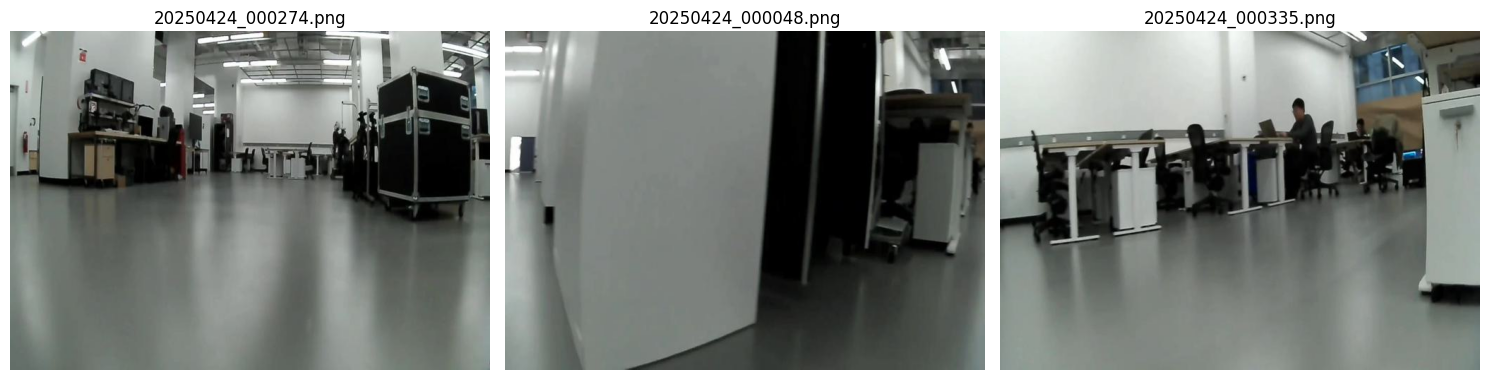

In [60]:
frame_id = get_random_frame_id()[0]
start_end = get_random_frame_names(frame_id)

env = MultiviewSceneGraph(frame_id, msg_file_path)
test_env = LMP_wrapper(env, cfg_tabletop)
print("Start point: ", start_end[0])
print("Goal point: ", start_end[1])
#print("pp_iou: ", env.json_data["eval_metrics"]["pp_iou"])
path = test_env.shortest_path(env.get_frame2index(start_end[0]), env.get_frame2index(start_end[1]))
frame_path = [env.get_index2frame(i) for i in path]
print(frame_path)
test_env.show_images_from_frames(frame_path)

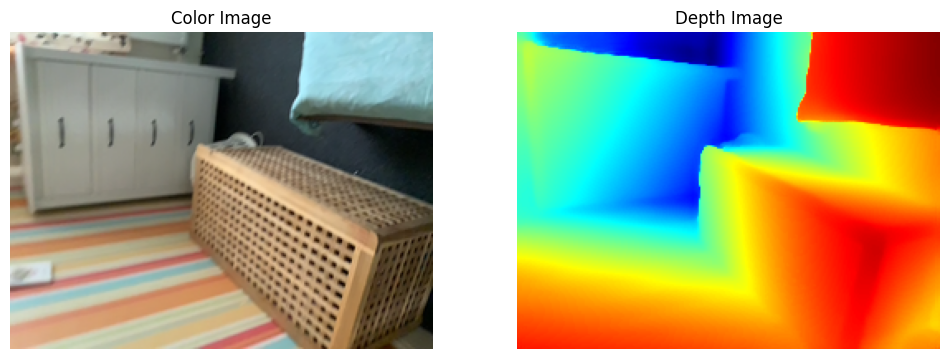

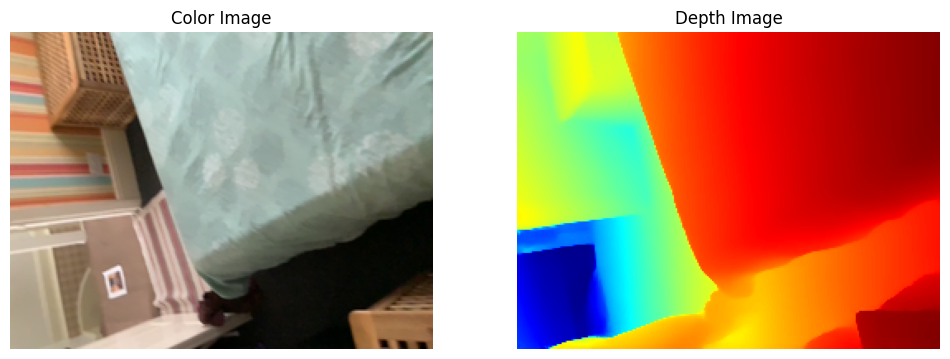

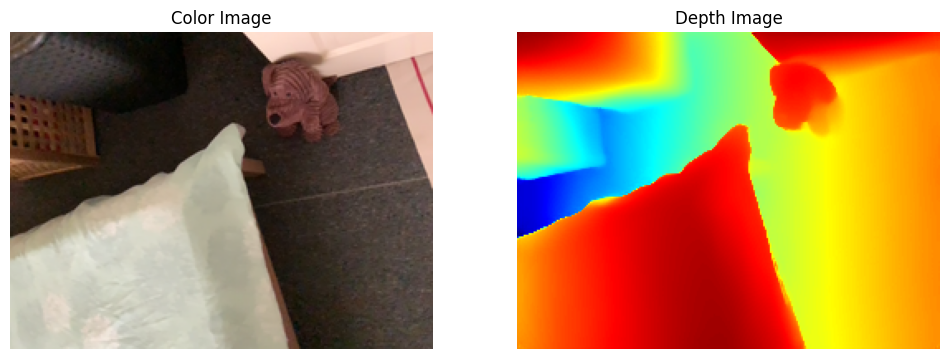

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the depth and color images
frame_ids = ['350030.474', '350024.960', '349993.473']

for frame_id in frame_ids:
    depth_image_path = "/mnt/NAS/data/jz4725/ARKitData/3dod/Validation/42446116/42446116_frames/lowres_depth/42446116_" + frame_id + ".png"
    color_image_path = "/mnt/NAS/data/jz4725/ARKitData/3dod/Validation/42446116/42446116_frames/lowres_wide/42446116_" + frame_id + ".png"
    
    depth_image = cv2.imread(depth_image_path, cv2.IMREAD_ANYDEPTH)
    color_image = cv2.imread(color_image_path, cv2.IMREAD_COLOR)
    
    # Check if images were loaded successfully
    if depth_image is None or color_image is None:
        print("Error: Could not open or find one of the images.")
    else:
        # Normalize the depth image to a range between 0 and 255 for visualization
        normalized_depth_image = cv2.normalize(depth_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        
        # Apply a colormap for better visualization
        colored_depth_image = cv2.applyColorMap(normalized_depth_image, cv2.COLORMAP_JET)
        
        # Convert color image from BGR to RGB for correct display in matplotlib
        color_image_rgb = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        
        # Plot both images side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        axes[0].imshow(color_image_rgb)
        axes[0].set_title("Color Image")
        axes[0].axis("off")
        
        axes[1].imshow(colored_depth_image)
        axes[1].set_title("Depth Image")
        axes[1].axis("off")
        
        plt.show()

In [4]:
import torch
import torch.nn as nn

class GoalMLP(torch.nn.Module):
    def __init__(self):
        super(GoalMLP, self).__init__()
        self.f1 = nn.Sequential(nn.Linear(512, 512), nn.ReLU(True))
        self.regression = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(True), nn.Linear(512, 256), nn.ReLU(True)
        )
        self.dist_predict = torch.nn.Linear(256, 1)
        self.rot_predict = torch.nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        self.initialize()

    def initialize(self):
        nn.init.xavier_uniform_(self.dist_predict.weight.data)
        self.dist_predict.bias.data.zero_()
        nn.init.xavier_uniform_(self.rot_predict.weight.data)
        self.rot_predict.bias.data.zero_()

    def forward(self, x1, x2):
        x = self.dropout(self.regression(torch.sub(self.f1(x1), self.f1(x2)).squeeze()))
        dist_output = self.dist_predict(x)
        rot_output = self.rot_predict(x)
        return dist_output, rot_output

In [5]:
"""Load Target function"""
model_goal = GoalMLP()
model_goal.load_state_dict(torch.load("QA_agent/gibson_goal_mlp.pt"))
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
model_goal.to(device)
model_goal.eval()

GoalMLP(
  (f1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
  )
  (regression): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
  )
  (dist_predict): Linear(in_features=256, out_features=1, bias=True)
  (rot_predict): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
def get_res_feats(img, resnet):
    mean = (
        torch.tensor([0.485, 0.456, 0.406])
        .view(1, 3, 1, 1)
        .to(device=next(resnet.parameters()).device)
    )
    std = (
        torch.tensor([0.229, 0.224, 0.225])
        .view(1, 3, 1, 1)
        .to(device=next(resnet.parameters()).device)
    )

    img = (
        torch.tensor(img)
        .unsqueeze(0)
        .to(device=next(resnet.parameters()).device)
        .permute(0, 3, 1, 2)
        .float()
        / 255
        - mean
    ) / std

    feats = resnet(img).detach().cpu().view(-1).unsqueeze(0)
    return feats

In [7]:
import torchvision.models as models
def load_places_resnet():
    # load the pre-trained weights
    model = models.__dict__["resnet18"](num_classes=365)
    model_file = "QA_agent/resnet18_places365.pth.tar"
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {
        str.replace(k, "module.", ""): v for k, v in checkpoint["state_dict"].items()
    }
    model.load_state_dict(state_dict)
    model = nn.Sequential(*(list(model.children())[:-1]))
    model.eval()
    model.to(device)
    return model

In [8]:
resnet = load_places_resnet()
import cv2

frame_ids = ['350030.474', '350024.960']
images_feats = []
for frame_id in frame_ids:
    color_image_path = "/mnt/NAS/data/jz4725/ARKitData/3dod/Validation/42446116/42446116_frames/lowres_wide/42446116_" + frame_id + ".png"
    color_image = cv2.imread(color_image_path, cv2.IMREAD_COLOR)
    
    feats = get_res_feats(color_image, resnet)
    images_feats.append(feats)


In [9]:

rho, phi = model_goal(
                images_feats[0].to(device), images_feats[1].to(device)
            )
rho = rho.cpu().detach().item()
phi = phi.cpu().detach().item()

In [10]:
print(rho, phi)

4.912817478179932 0.4188230037689209


In [11]:
curr_depth_img = get_depth_img_from_robot()
update_local_map(curr_depth_img)
set_goal(rho, phi)
action, terminate_local = navigate_local()

for _ in range(max_steps):
    sent_command_to_robot(action)
    curr_depth_img = get_depth_img_from_robot()
    update_local_map(curr_depth_img)
	action, terminate_local = navigate_local()
    if terminate_local == 1:
            break

TabError: inconsistent use of tabs and spaces in indentation (4191796416.py, line 10)